# Лабораторная работа 4.1 Построение и оценка модели для прогнозирования оттока клиентов

**Тема.** Интерпретация результатов модели для принятия бизнес-решений

**Курс.** Python для анализа данных

**Специальность.** Бизнес-информатика

### Цель работы:
Научиться применять модели машинного обучения (регрессию и классификацию) для решения реальных бизнес-задач, а также интерпретировать полученные результаты для формирования практических рекомендаций и принятия управленческих решений.

---

## Машинное обучение как инструмент бизнес-аналитика

В современном бизнесе данные — это стратегический актив. Способность предсказывать будущее поведение клиентов, оценивать риски и оптимизировать процессы напрямую влияет на прибыльность компании. Машинное обучение (ML) предоставляет для этого мощный инструментарий.

**Сквозной бизнес-кейс.** На протяжении всей этой работы мы будем решать одну из самых классических и важных задач — **прогнозирование оттока клиентов (Customer Churn)** на примере телеком-оператора.

**Почему это важно для бизнеса?**
- **Прямые финансовые потери.** Потерянный клиент — это потерянный доход.
- **Высокая стоимость привлечения.** Привлечь нового клиента в 5-7 раз дороже, чем удержать существующего.

Наша цель — не просто построить модель, которая предсказывает отток, а понять, **как использовать её результаты для реальных действий**: кому из клиентов предложить скидку, на какие факторы обратить внимание, чтобы снизить отток в будущем.

## Часть 1. Подготовка к анализу

Импортируем необходимые библиотеки и загрузим наш датасет.

In [1]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn scikit-learn -q

# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт инструментов для предобработки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Импорт метрик для оценки
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

**Задание 1: Загрузка и первичный осмотр данных**

Загрузите датасет по оттоку клиентов телеком-оператора по предоставленной ссылке. Выведите первые 5 строк (`.head()`) и общую информацию о данных (`.info()`).

In [ ]:
# URL датасета
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

# Ваш код здесь
# 1. Загрузите данные в DataFrame 'df'
df = pd.read_csv(url)

# 2. Выведите первые 5 строк
print("Первые 5 строк данных:")
display(df.head())
# 3. Выведите информацию о DataFrame
print("\nИнформация о данных")
df.info()


Первые 5 строк данных:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

## Часть 2. Исследовательский анализ данных (EDA) для бизнес-гипотез

Цель EDA — не просто посмотреть на данные, а найти в них инсайты, которые помогут нам в дальнейшем моделировании и принятии решений.

**Задание 2. Анализ целевой переменной**

Наша целевая переменная для задачи классификации — столбец `Churn` (Отток). Постройте столбчатую диаграмму (`countplot` из seaborn), чтобы визуализировать распределение классов. Сделайте вывод о сбалансированности классов.

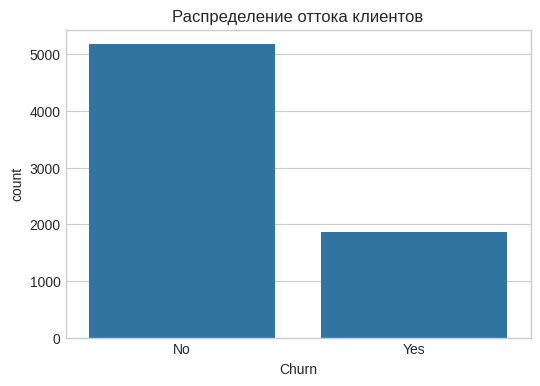

In [ ]:
# Ваш код здесь
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Распределение оттока клиентов')
plt.show()

# Вывод: классы несбалансированы, лояльных клиентов значительно больше, чем ушедших.
# Это нужно будет учитывать при оценке модели.

**Задание 3: Влияние типа контракта на отток**

**Бизнес-гипотеза.** Клиенты с краткосрочными контрактами (Month-to-month) более склонны к оттоку.
Проверьте эту гипотезу, построив `countplot` для столбца `Contract`, разделив его по значениям `Churn` (используйте параметр `hue`).

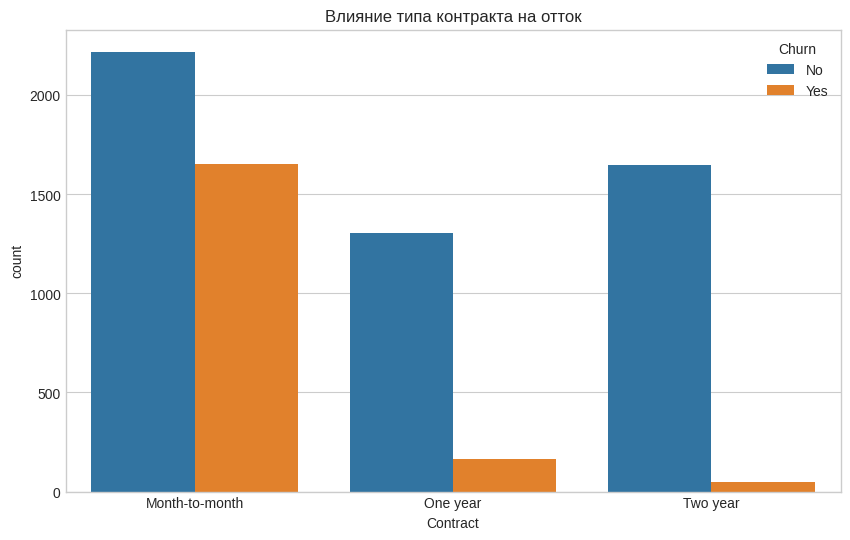

In [ ]:
# Ваш код здесь
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Влияние типа контракта на отток')
plt.show()

**Задание 4. Влияние ежемесячных платежей на отток**

**Бизнес-гипотеза.** Клиенты с более высокими ежемесячными платежами чаще уходят.
Проверьте это, построив `boxplot` (ящик с усами), где по оси X будет `Churn`, а по оси Y — `MonthlyCharges`.

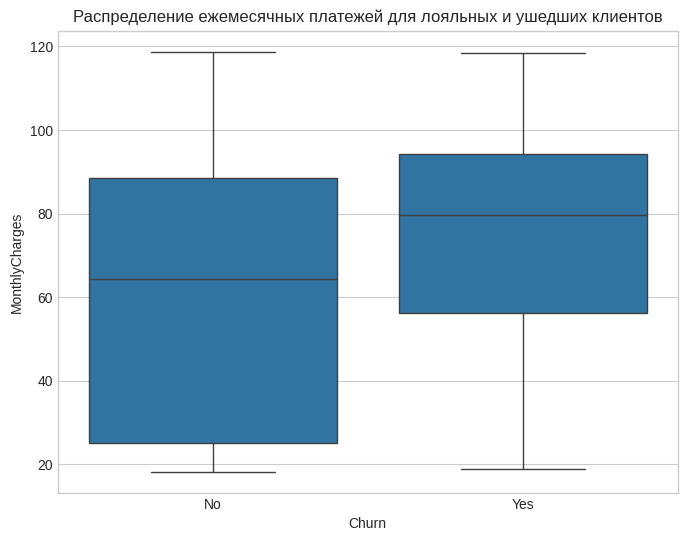

In [ ]:
# Ваш код здесь
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Распределение ежемесячных платежей для лояльных и ушедших клиентов')
plt.show()


## Часть 3. Подготовка данных для моделирования (Pre-processing)

Модели машинного обучения работают с числами. Нам нужно преобразовать наши данные: категориальные признаки — в числовые, а числовые — отмасштабировать.

**Задание 5. Предобработка данных**

Выполните следующие шаги:
1. `TotalCharges` имеет тип `object`. Преобразуйте его в числовой с помощью `pd.to_numeric`, а ошибки замените на `NaN` (`errors='coerce'`).
2. Заполните пропуски в `TotalCharges` медианным значением.
3. Целевую переменную `Churn` преобразуйте в 0 и 1.
4. Удалите ненужный для моделирования столбец `customerID`.

In [ ]:
# Ваш код здесь
# 1. Преобразование TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
# 2. Заполнение пропусков
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
# 3. Преобразование Churn
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
# 4. Удаление customerID
df.drop('customerID', axis=1, inplace=True)
df.info() # Проверка, что все типы данных корректны

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


/tmp/ipython-input-1739607127.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


**Задание 6. Разделение признаков и создание пайплайна**

1. Определите `X` (все столбцы, кроме `Churn`) и `y` (`Churn`).
2. Разделите `X` и `y` на обучающую и тестовую выборки (`train_test_split`) в соотношении 80/20.
3. Определите списки числовых (`numerical_features`) и категориальных (`categorical_features`) признаков.
4. Создайте пайплайн предобработки `preprocessor` с помощью `ColumnTransformer`, который будет масштабировать числовые признаки (`StandardScaler`) и кодировать категориальные (`OneHotEncoder`).

In [ ]:
# Ваш код здесь
# 1. Определение X и y
X = df.drop('Churn', axis=1)
y = df['Churn']
# 2. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Определение типов признаков
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 4. Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Пайплайн предобработки успешно создан.")

Пайплайн предобработки успешно создан.


## Часть 4. Задача классификации - Прогнозирование оттока

**Задание 7. Обучение модели логистической регрессии**

Создайте пайплайн `log_reg_pipeline`, который последовательно будет выполнять шаги `preprocessor` и обучать модель `LogisticRegression`. Обучите этот пайплайн на `X_train`, `y_train`.

In [ ]:
# Ваш код здесь
log_reg_pipepline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', LogisticRegression(random_state=42))])
log_reg_pipepline.fit(X_train, y_train)
print("Модель логистической регрессии обучена")

Модель логистической регрессии обучена


**Задание 8. Оценка модели и интерпретация для бизнеса**

1. Сделайте предсказания на тестовой выборке (`X_test`).
2. Рассчитайте `accuracy`.
3. Постройте **матрицу ошибок (confusion matrix)** и проинтерпретируйте её с точки зрения бизнеса.

Точность (Accuracy): 0.81


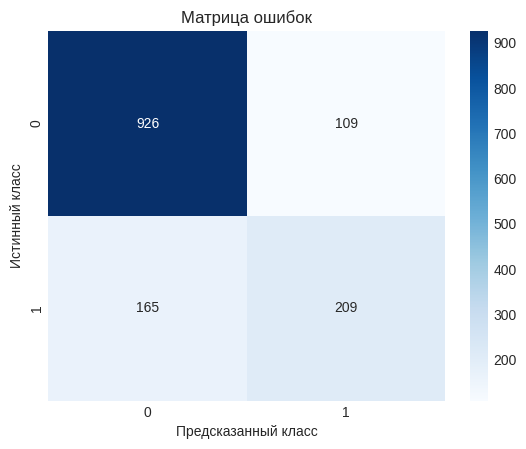

In [ ]:
# Ваш код здесь
# 1. Предсказания
y_pred = log_reg_pipepline.predict(X_test)

# 2. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

# 3. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Интерпретация для бизнеса:
# True Negative (TN, левый верхний угол). Мы правильно определили лояльных клиентов. Это хорошо.
# False Positive (FP, правый верхний угол). Мы ошибочно предсказали отток лояльному клиенту. Бизнес-риск: мы можем потратить деньги на удержание клиента, который и так бы не ушел.
# False Negative (FN, левый нижний угол). Мы не смогли предсказать отток, и клиент ушел. Это самая большая проблема! Мы упустили возможность его удержать и потеряли доход.
# True Positive (TP, правый нижний угол). Мы правильно предсказали отток. Это позволяет нам вовремя принять меры.

<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
y_pred = log_reg_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
```

</details>

**Задание 9. Анализ важности признаков**

Для линейных моделей, таких как логистическая регрессия, мы можем посмотреть на коэффициенты, чтобы понять, какие признаки наиболее сильно влияют на отток. Извлеките коэффициенты и названия признаков из пайплайна и создайте DataFrame для их анализа.

In [ ]:
# Ваш код здесь
try:
    # Получаем названия закодированных признаков из препроцессора
    feature_names = log_reg_pipepline.named_steps['preprocessor'].get_feature_names_out()

    # Получаем коэффициенты из классификатора
    # ИСПРАВЛЕНИЕ: Добавляем [0], так как coef_ возвращает массив вида [[...]], а нам нужен плоский список
    coefficients = log_reg_pipepline.named_steps['classifier'].coef_[0]

    # Создаем DataFrame
    coef_df = pd.DataFrame({'Признак': feature_names, 'Коэффициент': coefficients})

    # Рассчитываем абсолютное значение влияния
    coef_df['Влияние'] = np.abs(coef_df['Коэффициент'])

    # Сортируем по силе влияния
    coef_df = coef_df.sort_values(by='Влияние', ascending=False)

    print("Топ-10 признаков, влияющих на отток:")
    display(coef_df.head(10))

    # Бизнес-интерпретация:
    # Положительные коэффициенты (ближе к верху списка, если они положительные) увеличивают вероятность оттока.
    # Отрицательные коэффициенты уменьшают вероятность оттока (удерживают клиента).

except Exception as e:
    print(f"Ошибка при извлечении признаков: {e}")

Топ-10 признаков, влияющих на отток:


,Признак,Коэффициент,Влияние
1,num__tenure,-1.241015,1.241015
38,cat__Contract_Two year,-0.773004,0.773004
15,cat__InternetService_DSL,-0.652640,0.652640
16,cat__InternetService_Fiber optic,0.640185,0.640185
2,num__MonthlyCharges,-0.596379,0.596379
36,cat__Contract_Month-to-month,0.579853,0.579853
3,num__TotalCharges,0.516280,0.516280
39,cat__PaperlessBilling_No,-0.343088,0.343088
25,cat__DeviceProtection_No internet service,-0.301064,0.301064
17,cat__InternetService_No,-0.301064,0.301064


<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
try:
    # Получаем названия закодированных признаков из препроцессора
    feature_names = log_reg_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Получаем коэффициенты из классификатора
    # ИСПРАВЛЕНИЕ: Добавляем [0], так как coef_ возвращает массив вида [[...]], а нам нужен плоский список
    coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]

    # Создаем DataFrame
    coef_df = pd.DataFrame({'Признак': feature_names, 'Коэффициент': coefficients})
    
    # Рассчитываем абсолютное значение влияния
    coef_df['Влияние'] = np.abs(coef_df['Коэффициент'])
    
    # Сортируем по силе влияния
    coef_df = coef_df.sort_values(by='Влияние', ascending=False)

    print("Топ-10 признаков, влияющих на отток:")
    display(coef_df.head(10))
    
    # Бизнес-интерпретация:
    # Положительные коэффициенты (ближе к верху списка, если они положительные) увеличивают вероятность оттока.
    # Отрицательные коэффициенты уменьшают вероятность оттока (удерживают клиента).
    
except Exception as e:
    print(f"Ошибка при извлечении признаков: {e}")
```

</details>

## Часть 5. Задача регрессии - Прогнозирование ценности клиента (LTV)

Не все клиенты одинаково ценны. Прогнозирование **LTV (Lifetime Value)**, или в нашем случае, `TotalCharges` (общие расходы клиента), поможет понять, на удержание каких клиентов стоит тратить больше усилий.

**Задание 10. Подготовка данных для регрессии**

Целевая переменная теперь — `TotalCharges`.
1. Создайте `X_reg` (все столбцы, кроме `TotalCharges` и `customerID`, `Churn`) и `y_reg` (`TotalCharges`).
2. Разделите данные на обучающую и тестовую выборки.

In [ ]:
# Загрузим и очистим данные заново для чистоты эксперимента
df_reg = pd.read_csv(url)
df_reg['TotalCharges'] = pd.to_numeric(df_reg['TotalCharges'], errors='coerce')
df_reg.dropna(inplace=True)

# Ваш код здесь
# 1. Определение X и y
X_reg = df_reg.drop(['customerID', 'TotalCharges', 'Churn'], axis=1)
y_reg = df_reg['TotalCharges']

# 2. Разделение на train/test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Данные для регрессии подготовлены.")

Данные для регрессии подготовлены.


**Задание 11. Обучение модели линейной регрессии**

Создайте пайплайн для линейной регрессии, который включает `preprocessor` (тот же, что и раньше, но адаптированный под новые `X`) и модель `LinearRegression`. Обучите его.

In [ ]:
# Ваш код здесь
numerical_features_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns
categorical_features_reg = X_reg.select_dtypes(include=['object']).columns

preprocessor_reg = ColumnTransformer(
     transformers=[
         ('num', StandardScaler(), numerical_features_reg),
         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg)
     ])

lin_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                  ('regressor', LinearRegression())])

lin_reg_pipeline.fit(X_train_reg, y_train_reg)
print("Модель линейной регрессии обучена.")

Модель линейной регрессии обучена.


**Задание 12. Оценка и интерпретация модели регрессии**

1. Сделайте предсказания на `X_test_reg`.
2. Рассчитайте метрики **RMSE** и **R² (R-squared)**.
3. Визуализируйте результат: постройте диаграмму рассеяния (`scatterplot`), где по одной оси будут реальные значения, а по другой — предсказанные.

RMSE: 673.95
R-squared: 0.91


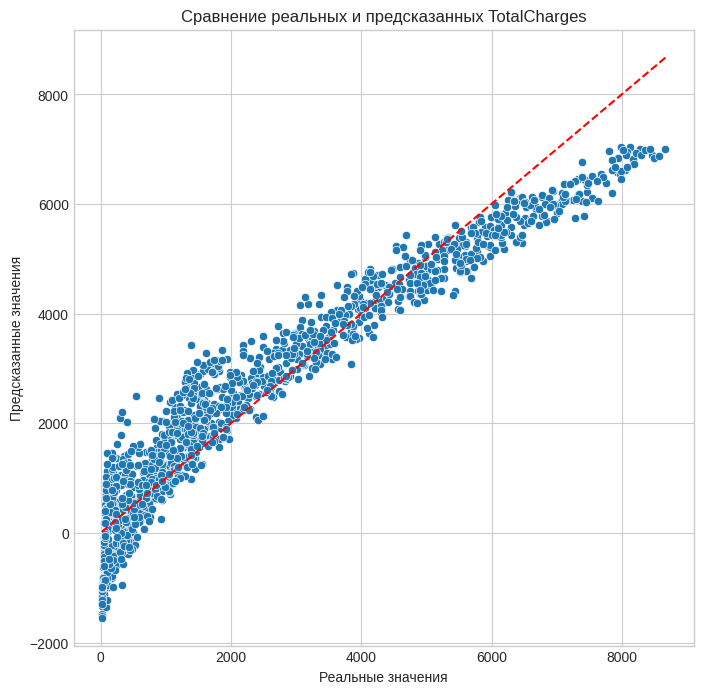

In [ ]:
# Ваш код здесь
# 1. Предсказания
y_pred_reg = lin_reg_pipeline.predict(X_test_reg)

rmse_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2_reg = r2_score(y_test_reg, y_pred_reg)

# 2. Метрики
print(f"RMSE: {rmse_reg:.2f}")
print(f"R-squared: {r2_reg:.2f}")

# 3. Визуализация
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.title('Сравнение реальных и предсказанных TotalCharges')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.show()

# Бизнес-интерпретация:
# RMSE показывает среднюю ошибку прогноза в долларах. R² показывает, какую долю дисперсии целевой переменной объясняет наша модель.
# На графике идеальный прогноз лежал бы на диагональной линии. Мы видим, что модель в целом улавливает тренд, но имеет заметную ошибку.

## Часть 6. Комплексное бизнес-решение

Теперь объединим результаты обеих моделей для принятия взвешенного решения.

**Задание 13. Создание финального DataFrame с прогнозами**

Сделайте предсказания обеими моделями на всем датасете и добавьте их как новые столбцы: `churn_probability` (вероятность оттока) и `predicted_ltv`.

In [ ]:
# Убедимся, что df_final не содержит лишних колонок
df_final = df.drop('Churn', axis=1).copy()

# Предсказание вероятности оттока (берем вероятность класса '1')
df_final['churn_probability'] = log_reg_pipepline.predict_proba(df_final)[:, 1]

# Предсказание LTV
df_final['predicted_ltv'] = lin_reg_pipeline.predict(df_final.drop('churn_probability', axis=1))

print("Финальный DataFrame с прогнозами:")
display(df_final[['tenure', 'MonthlyCharges', 'TotalCharges', 'churn_probability', 'predicted_ltv']].head())

Финальный DataFrame с прогнозами:


,tenure,MonthlyCharges,TotalCharges,churn_probability,predicted_ltv
0,1,29.85,29.85,0.612477,-1029.111908
1,34,56.95,1889.50,0.044601,2241.371627
2,2,53.85,108.15,0.298861,278.429079
3,45,42.30,1840.75,0.028576,2491.085068
4,2,70.70,151.65,0.691602,63.498266


**Задание 14. Сегментация клиентов для принятия решений**

**Бизнес-задача.** Нам нужно выделить сегмент клиентов, на удержание которых стоит потратить ресурсы в первую очередь.
**Критерии.**
1. Высокая вероятность оттока (`churn_probability > 0.6`).
2. Высокая прогнозируемая ценность (`predicted_ltv` выше 75-го перцентиля).

Отфильтруйте `df_final` по этим двум критериям и выведите результат.

In [ ]:
# Рассчитываем порог LTV
ltv_threshold = df_final['predicted_ltv'].quantile(0.75)

# Фильтруем клиентов
high_value_churn_segment = df_final[
    (df_final['churn_probability'] > 0.6) &
    (df_final['predicted_ltv'] > ltv_threshold)
]

print(f"Найдено {len(high_value_churn_segment)} клиентов в сегменте 'приоритет на удержание'.")
print("Это ценные клиенты с высокой вероятностью оттока, которым следует предложить скидки или бонусы.")
display(high_value_churn_segment.head())


Найдено 11 клиентов в сегменте 'приоритет на удержание'.
Это ценные клиенты с высокой вероятностью оттока, которым следует предложить скидки или бонусы.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_probability,predicted_ltv
38,Male,0,No,No,34,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.35,3549.25,0.618049,4042.168035
574,Female,1,Yes,No,28,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,110.85,3204.40,0.619527,4028.121032
1081,Male,1,Yes,No,46,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.85,4564.90,0.622676,4238.582650
1125,Male,1,Yes,No,39,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,105.65,4284.80,0.640669,4328.027694
1630,Male,1,Yes,No,38,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,102.60,4009.20,0.651735,4164.662100


---

## Часть 7. Индивидуальный проект - "Построение и оценка модели для прогнозирования оттока клиентов"

**Цель:** Самостоятельно провести полный цикл построения модели оттока для выбранной предметной области, используя знания, полученные в ходе выполнения лабораторной работы.

### Инструкция
1.  **Выберите ваш вариант** из списка ниже.
2.  **Найдите подходящий датасет на Kaggle.** Используйте ключевые слова из вашего варианта (например, `e-commerce customer churn`, `banking churn dataset`). Датасет должен содержать целевую переменную (факт оттока) и не менее 5-7 признаков.
3.  **Проведите полный цикл анализа**, аналогичный тому, что был выполнен в этой тетради:
    *   Загрузка и первичный осмотр данных.
    *   Исследовательский анализ (EDA) с построением 2-3 гипотез и их визуальной проверкой.
    *   Предобработка данных (обработка пропусков, кодирование категорий, масштабирование).
    *   Разделение на обучающую и тестовую выборки.
    *   Построение модели классификации (например, `LogisticRegression` или `RandomForestClassifier`).
    *   Оценка модели (accuracy, confusion matrix) и **интерпретация результатов с точки зрения бизнеса**.
4.  Оформите ваше решение в виде Jupyter Notebook, сохранив все выводы и графики.

### Варианты заданий

1.  **Ритейл (одежда).** Прогнозирование оттока клиентов из программы лояльности.
2.  **SaaS-сервис (B2B).** Прогнозирование отказа компаний от подписки на ПО.
3.  **Банковский сектор.** Прогнозирование ухода клиентов из банка (закрытие счета).
4.  **Фитнес-центр.** Прогнозирование отказа клиентов от продления абонемента.
5.  **Онлайн-кинотеатр.** Прогнозирование отказа от платной подписки.
6.  **Игровая индустрия.** Прогнозирование ухода игроков из онлайн-игры.
7.  **E-commerce (электроника).** Прогнозирование оттока покупателей.
8.  **Стриминговый музыкальный сервис.** Прогнозирование отказа от premium-подписки.
9.  **Страховая компания.** Прогнозирование расторжения страхового полиса.
10. **Образовательная платформа.** Прогнозирование ухода студентов с онлайн-курса.
11. **Телеком (мобильная связь).** Аналогично примеру, но с другим датасетом.
12. **Каршеринг.** Прогнозирование прекращения использования сервиса клиентами.
13. **Сервис доставки еды.** Прогнозирование оттока пользователей.
14. **Гостиничный бизнес.** Прогнозирование отказа участников программы лояльности отелей.
15. **Авиакомпания.** Прогнозирование ухода участников программы для часто летающих пассажиров.
16. **Облачные сервисы (IaaS/PaaS).** Прогнозирование ухода разработчиков с платформы.
17. **Новостной портал (подписка).** Прогнозирование отказа от платной подписки на контент.
18. **Ритейл (продукты).** Прогнозирование оттока покупателей из сети супермаркетов.
19. **HR-аналитика.** Прогнозирование увольнения сотрудников (внутренний отток).
20. **Кредитные организации.** Прогнозирование ухода клиентов, пользующихся кредитными картами.
21. **SaaS-сервис (B2C).** Прогнозирование отказа индивидуальных пользователей от подписки.
22. **Маркетплейс.** Прогнозирование ухода продавцов с платформы.
23. **Энергетическая компания.** Прогнозирование смены поставщика электроэнергии.
24. **Сервис аренды жилья.** Прогнозирование ухода арендодателей с платформы.
25. **CRM-системы.** Прогнозирование отказа клиентов от использования CRM.
26. **Фармацевтический ритейл.** Прогнозирование оттока клиентов аптечной сети.
27. **Букмекерские конторы.** Прогнозирование ухода игроков.
28. **Косметический бренд.** Прогнозирование оттока покупателей из онлайн-магазина.
29. **Сервис для путешествий.** Прогнозирование оттока пользователей, бронирующих отели/билеты.
30. **Инвестиционная платформа.** Прогнозирование ухода инвесторов.
31. **Автосервис.** Прогнозирование ухода постоянных клиентов.
32. **Ветеринарная клиника.** Прогнозирование оттока владельцев животных.
33. **Коворкинг.** Прогнозирование отказа резидентов от продления аренды.
34. **Сервис по подписке на кофе/чай.** Прогнозирование отмены подписки.
35. **Благотворительная организация.** Прогнозирование прекращения регулярных пожертвований.

In [2]:
# Вариант 7
# 1. Загрузка и первичный осмотр данных
#df2 = pd.read_csv('ecommerce_customer_data_custom_ratios.csv')
df2 = pd.read_csv('data_ecommerce_customer_churn.csv')
print("Первые 5 строк данных:")
display(df2.head())
print("\nИнформация о данных")
df2.info()


Первые 5 строк данных:


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0



Информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


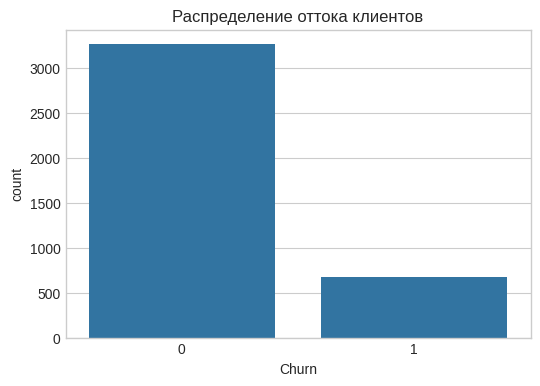

In [3]:
# Исследовательский анализ (EDA)
# Анализ целевой переменной Churn
plt.figure(figsize=(6, 4))
sns.countplot(data=df2, x='Churn')
plt.title('Распределение оттока клиентов')
plt.show()

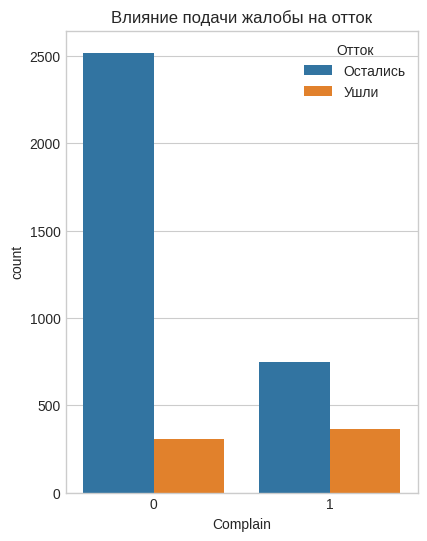

In [4]:
# Бизнес-гипотеза 1 Клиенты, которые подавали жалобу более склоннны к оттоку
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(1, 2, 1)
sns.countplot(data=df2, x='Complain', hue='Churn', ax=ax1)
plt.title('Влияние подачи жалобы на отток')
plt.legend(title='Отток', labels=['Остались', 'Ушли'])
plt.show()

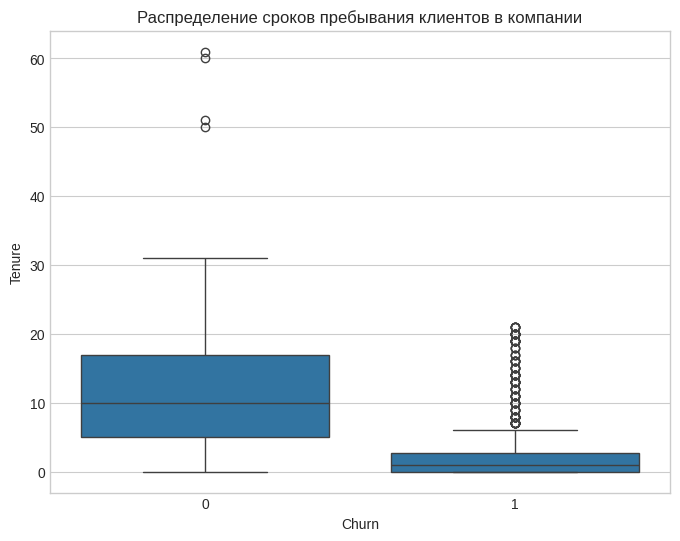

In [5]:
# Бизнес-гипотеза 2 Клиенты с маленькими сроком пребывании в компании чаще уходят
plt.figure(figsize=(8,6))
sns.boxplot(data=df2, x='Churn', y='Tenure')
plt.title('Распределение сроков пребывания клиентов в компании')
plt.show()

In [6]:
# Предобработка данных
# Округление CashbackAmount до 2 знаков
df2['CashbackAmount'] = df2['CashbackAmount'].round(2)
# Заполнение пропусков
df2['Tenure'].fillna(df2['Tenure'].median(), inplace=True)
df2['WarehouseToHome'].fillna(df2['WarehouseToHome'].median(), inplace=True)
df2['DaySinceLastOrder'].fillna(df2['DaySinceLastOrder'].median(), inplace=True)
display(df2.head())
df2.info() # Проверка, что все типы данных корректны

/tmp/ipython-input-275284301.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Tenure'].fillna(df2['Tenure'].median(), inplace=True)
/tmp/ipython-input-275284301.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,3.0,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3941 non-null   float64
 1   WarehouseToHome           3941 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3941 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [7]:
# Разделение на обучающую и тестовую выборки
X2 = df2.drop('Churn', axis=1)
y2 = df2['Churn']
# 2. Разделение на train/test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

# 3. Определение типов признаков
numerical_features2 = X2.select_dtypes(include=['int64', 'float64']).columns
categorical_features2 = X2.select_dtypes(include=['object']).columns

# 4. Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features2),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features2)
    ])

print("Пайплайн предобработки успешно создан.")

Пайплайн предобработки успешно создан.


In [8]:
# Построение модели
log_reg_pipepline2 = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', LogisticRegression(random_state=42))])
log_reg_pipepline2.fit(X2_train, y2_train)
print("Модель логистической регрессии обучена")

Модель логистической регрессии обучена


Точность (Accuracy): 0.87


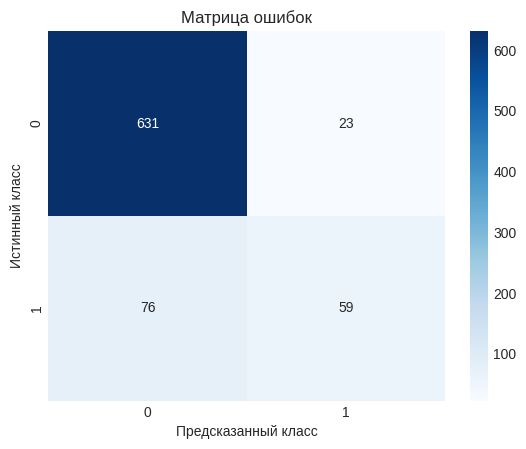

In [9]:
# Оценка модели (accuracy, confusion matrix) и интерпретация результатов с точки зрения бизнеса.
# 1. Предсказания
y_pred2 = log_reg_pipepline2.predict(X2_test)

# 2. Accuracy
accuracy2 = accuracy_score(y2_test, y_pred2)
print(f"Точность (Accuracy): {accuracy2:.2f}")

# 3. Матрица ошибок
cm2 = confusion_matrix(y2_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Интерпретация для бизнеса:
# True Negative (TN, левый верхний угол). Мы правильно определили лояльных клиентов. Это хорошо.
# False Positive (FP, правый верхний угол). Мы ошибочно предсказали отток лояльному клиенту. Бизнес-риск: мы можем потратить деньги на удержание клиента, который и так бы не ушел.
# False Negative (FN, левый нижний угол). Мы не смогли предсказать отток, и клиент ушел. Это самая большая проблема! Мы упустили возможность его удержать и потеряли доход.
# True Positive (TP, правый нижний угол). Мы правильно предсказали отток. Это позволяет нам вовремя принять меры.